### Classification model that predicts the species of iris flowers Using Support Vector Machine (SVM) with K-fold cross-validation

In [106]:
# Import dependencies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report


In [107]:
# Load the dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

By reviewing the `iris.DESCR` output, the dataset has no missing values

In [108]:
# Review the data
pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), columns=iris.feature_names + ['Species']).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Perform PCA analysis on the dataset

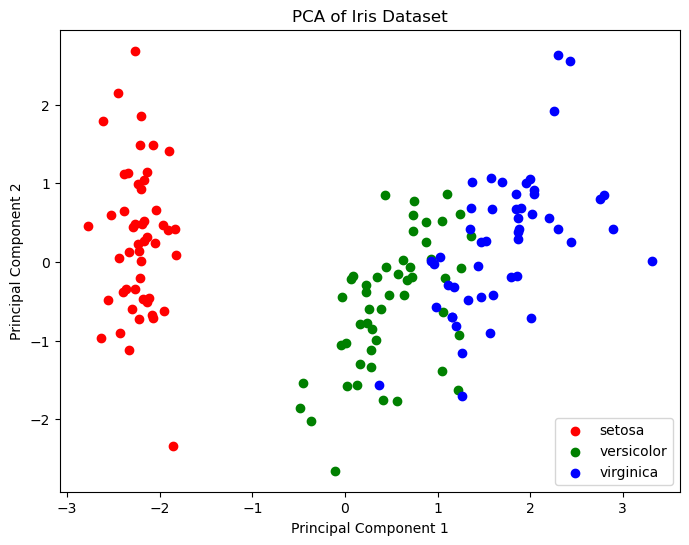

In [109]:
data = pd.DataFrame(X, columns=iris.feature_names)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenate the principal components with the target variable
final_df = pd.concat([principal_df, pd.DataFrame(data=iris.target, columns=['target'])], axis=1)

# Plot the PCA result
plt.figure(figsize=(8, 6))
targets = np.unique(iris.target)
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indices_to_keep = final_df['target'] == target
    plt.scatter(final_df.loc[indices_to_keep, 'PC1'],
                final_df.loc[indices_to_keep, 'PC2'],
                c=color,
                label=iris.target_names[target])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Iris Dataset')
plt.legend()
plt.show()


In [110]:
# Split the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=13)

SVMs are sensistive to the scale of the input features, so we're going to standardize the feature sets

In [111]:
# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

Experimenting with different SVM kernels and parameters to find the optimal model

In [112]:
# Define the parameter grid, specifying various kernel types and params
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Initialise the model
svm = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search with cross-validation
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

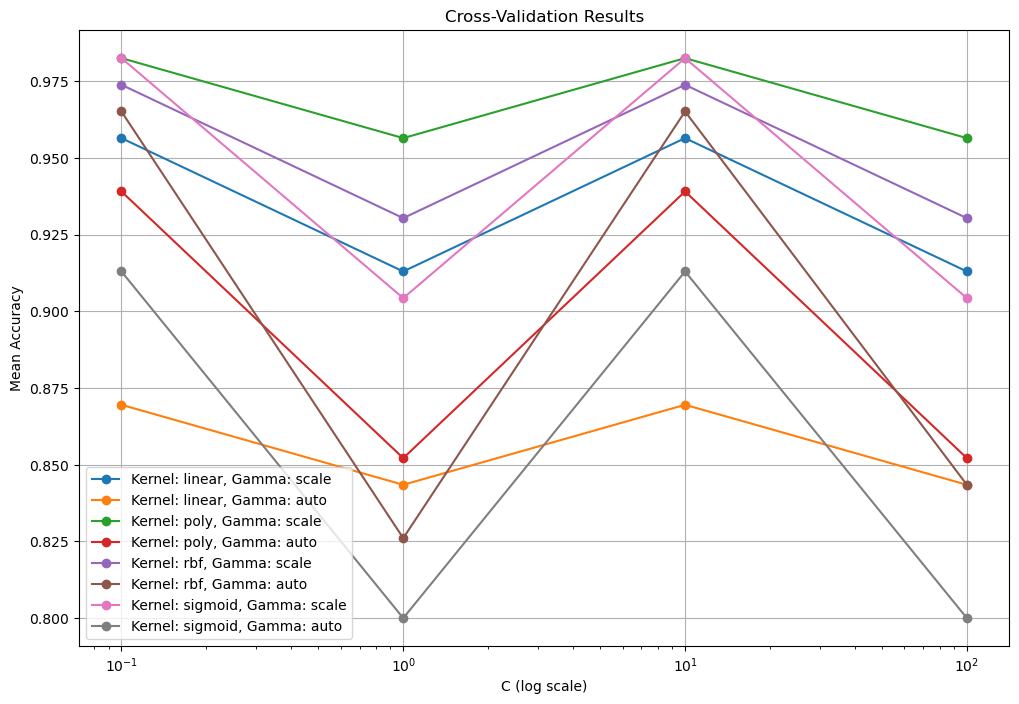

In [113]:
# Get the results for plotting
results = grid_search.cv_results_
mean_scores = np.array(results['mean_test_score'])

# Reshape the scores to a matrix for plotting
mean_scores = mean_scores.reshape(len(param_grid['kernel']), len(param_grid['C']), len(param_grid['gamma']))

# Plotting
plt.figure(figsize=(12, 8))

for ind, kernel in enumerate(param_grid['kernel']):
    for jnd, gamma in enumerate(param_grid['gamma']):
        plt.plot(param_grid['C'], mean_scores[ind, :, jnd], '-o', label=f'Kernel: {kernel}, Gamma: {gamma}')

plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean Accuracy')
plt.title('Cross-Validation Results')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9826086956521738


****Discussion:****
- We observe that the linear kernel gives us the best score

In [115]:
# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred 

array([1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0,
       0, 2, 1, 2, 0, 2, 1, 2, 2, 0, 0, 2, 2])

In [116]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9714285714285714


In [117]:
# Generate a classification report
print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        11
  versicolor       0.89      1.00      0.94         8
   virginica       1.00      0.94      0.97        16

    accuracy                           0.97        35
   macro avg       0.96      0.98      0.97        35
weighted avg       0.97      0.97      0.97        35



Using K-fold cross-validation to assess the performance of the model 

In [118]:

# Initialize the SVM classifier
svc = SVC(kernel='rbf', C=1, gamma='scale')  # Example parameters

# Define the number of folds for K-fold cross-validation
k = 10

# Initialize KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Scale the features and perform K-fold cross-validation
accuracy_scores = cross_val_score(svc, scaler.fit_transform(X), y, cv=kf, scoring='accuracy')

# Print the accuracy scores for each fold
print("Accuracy Scores for Each Fold:", accuracy_scores)

# Calculate the mean accuracy and standard deviation
mean_accuracy = accuracy_scores.mean()
std_accuracy = accuracy_scores.std()

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Accuracy Scores for Each Fold: [1.         1.         1.         0.93333333 1.         0.86666667
 0.86666667 1.         1.         0.93333333]
Mean Accuracy: 0.9600000000000002
Standard Deviation of Accuracy: 0.05333333333333332


***References***

[1]	B. Bedi, ‘SVM Kernels Cross Validation and HyperParameter tuning #machinelearning #data’. [www.youtube.com](https://www.youtube.com/watch?v=ZobQggQtRt8&ab_channel=CloudFitness), 10 2023.

[2]	SciKit-Learn, ‘3.1. Cross-validation: evaluating estimator performance — scikit-learn 0.21.3 documentation’. [Scikit-learn.org](https://scikit-learn.org/stable/modules/cross_validation.html), 2009.

